In [2]:
import numpy as np

np.random.seed(42)

steps = np.random.randn(1000)
steps[0] = 0

random_walk = np.cumsum(steps)

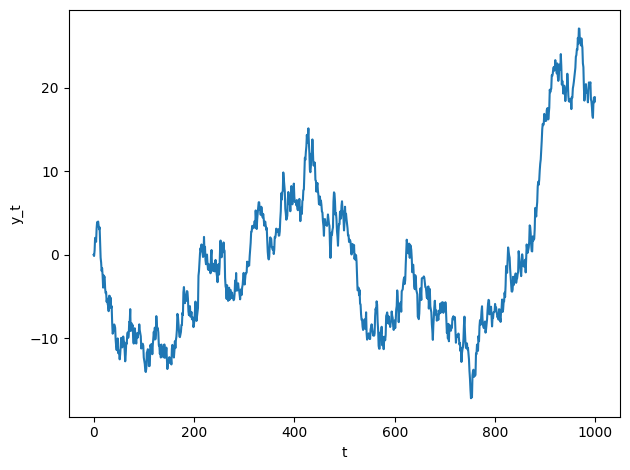

In [3]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

fig, ax = plt.subplots()
ax: Axes
ax.plot(random_walk)
ax.set_xlabel(r't')
ax.set_ylabel(r'y_t')
plt.tight_layout()

In [4]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(random_walk)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -0.9659524876918755
p-value: 0.7654789696692579


A p-value of 0.77  

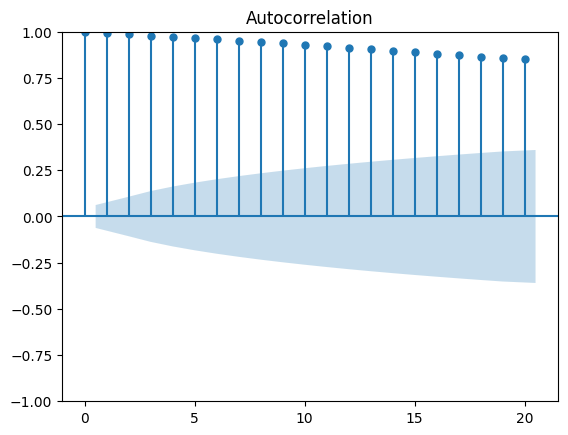

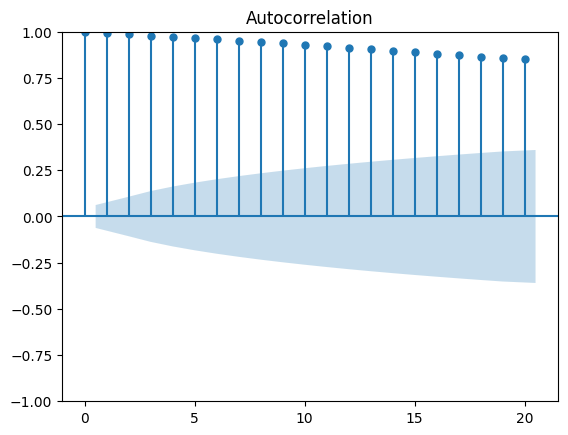

In [5]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(random_walk, lags=20)

The autocorrelation coefficients going down as the lag increases is a clear indicator that the a random walk is not a stationary process. Note the shaded area: if a point is within the shaded area, the it is not significantly different from 0. Otherwise, the autocorrelation coefficient is significant. Since our random walk is not stationary, we need to transform it to retrieve useful info from the ACF plot.

In [7]:
diff_random_walk = np.diff(random_walk, n=1)

ADF_result = adfuller(diff_random_walk)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -31.789310857560594
p-value: 0.0


This time the ADF statistic is a large negative number, and the p-value is less than 0.05. $\therefore$ we reject the null hypothesis, and say that this process has no unit root and is thus stationary.

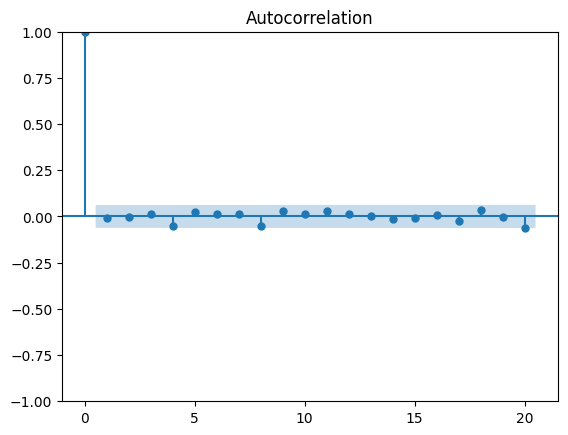

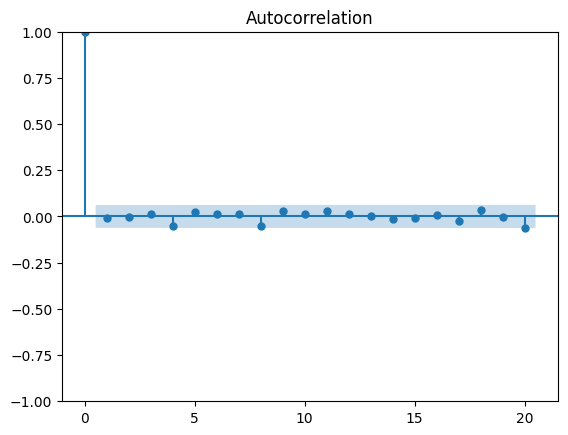

In [8]:
plot_acf(diff_random_walk, lags=20)

Notice how there are no significant coefficients after lag 0 $\therefore$ we're dealing with a random walk.

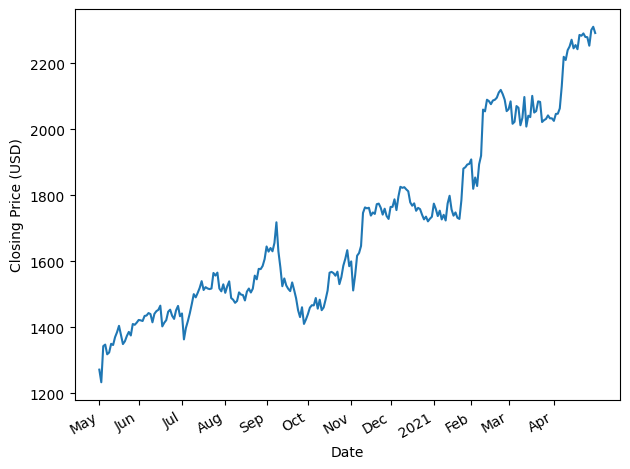

In [39]:
import pandas as pd
import datetime

df = pd.read_csv('data/GOOGL.csv')

fig, ax = plt.subplots()
ax: Axes
ax.plot(df['Date'], df['Close'])
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price (USD)')
ticks, labels = [], []
prev_month, prev_year = None, None
for i, date_str in enumerate(df['Date'][4:]):
    date = datetime.datetime.strptime(date_str, '%Y-%m-%d')
    if prev_year and date.year != prev_year:
        ticks.append(i)
        labels.append(date.strftime('%Y'))
    elif (prev_month and date.month != prev_month) or not prev_month:
        ticks.append(i)
        labels.append(date.strftime('%b'))
    prev_month = date.month; prev_year = date.year
plt.xticks(ticks, labels)
fig.autofmt_xdate()
plt.tight_layout()

In [41]:
GOOGL_ADF_result = adfuller(df['Close'])
print(f'ADF Statistic: {GOOGL_ADF_result[0]}')
print(f'p-value: {GOOGL_ADF_result[1]}')

ADF Statistic: 0.16025048664771283
p-value: 0.9699419435913057


ADF statistic of 0.16 and a p-value of $0.96 > 0.05$, $\therefore$ this data is not stationary. Let's try and make it stationary:

In [43]:
diff_close = np.diff(df['Close'], n=1)
GOOGL_diff_ADF_result = adfuller(diff_close)
print(f'ADF Statistic: {GOOGL_diff_ADF_result[0]}')
print(f'p-value: {GOOGL_diff_ADF_result[1]}')

ADF Statistic: -5.303439704295231
p-value: 5.386530961454658e-06


ADF static is a ~large negative number, and the p-value is less than 0.05, $\therefore$ we now have a stationary process.

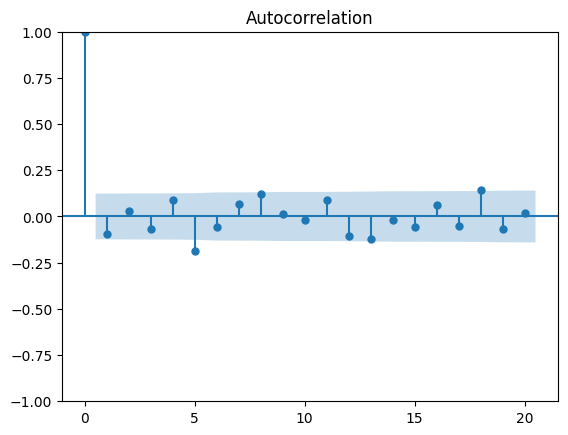

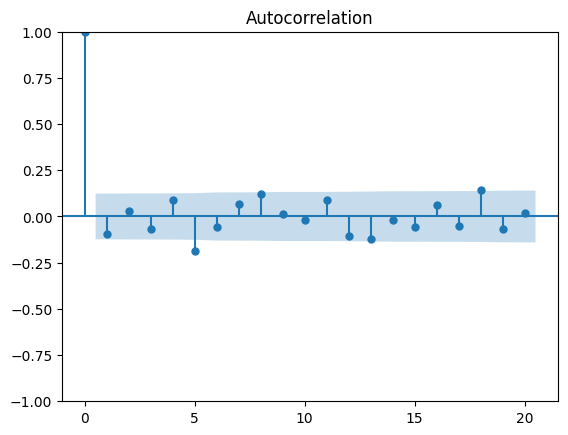

In [44]:
plot_acf(diff_close, lags=20)

With a few exceptions, there are generally no significant autocorrelation coefficients after lag 0, $\therefore$ we're dealing with a random walk.

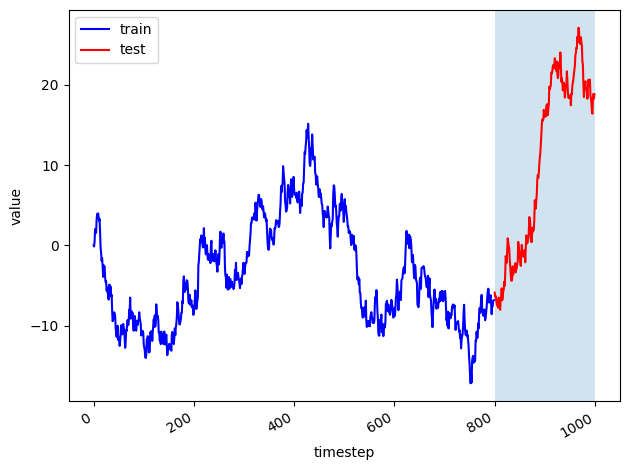

In [95]:
df = pd.DataFrame({'value': random_walk})
train_test_split = int(0.8*len(df))
train = df[:train_test_split]
test = df[train_test_split:]

from typing import Optional
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

def plot(
    train: pd.DataFrame,
    test: pd.DataFrame,
    pred_cols: Optional[list[str]] = [],
    styles: list[str] = ['r-.', 'g--', 'k:']
):
    fig, ax = plt.subplots()
    ax: Axes
    ax.plot(range(train_test_split), train['value'], 'b-', label='train')
    ax.plot(range(train_test_split, len(df)), test['value'], 'r-', label='test')
    if pred_cols:
        for i, col in enumerate(pred_cols):
            ax.plot(range(train_test_split, len(df)), 
                    test[col], 
                    styles[i % len(styles)],
                    label=col)
    ax.set_xlabel('timestep')
    ax.set_ylabel('value')
    ax.axvspan(train_test_split, len(df), alpha=0.2)
    ax.legend(loc=2)
    fig.autofmt_xdate()
    plt.tight_layout()

# mean absolute % error
def mape(y_true: np.ndarray, y_pred: np.ndarray):
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

def eval(
    test: pd.DataFrame,
    pred_col: str
):
    return mape(test['value'], test[pred_col])

plot(train, test)

-3.68


235.42225616507565

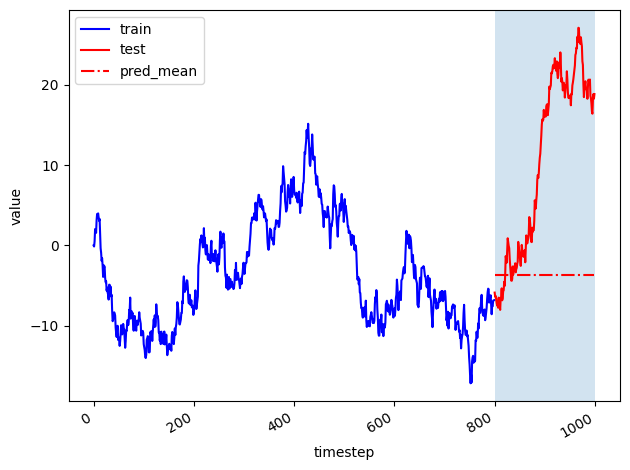

In [96]:
mean = np.mean(train['value'])
print(f'{mean:.2f}')
test = test.assign(pred_mean=mean)
plot(train, test, ['pred_mean'])
eval(test, 'pred_mean')

In [98]:
last_value = train.iloc[-1]['value']
test = test.assign(pred_last=last_value)

In [99]:
deltaX = len(train)-1
deltaY = train['value'].iloc[-1]-train['value'].iloc[0]
drift = deltaY / deltaX
print(f'{drift:.4f}')

-0.0085


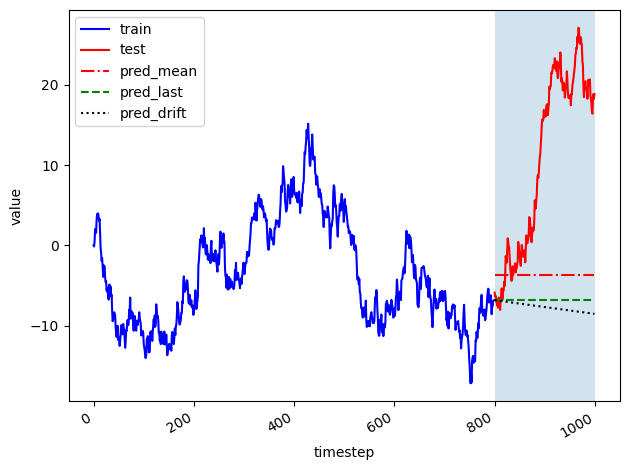

In [100]:
x_vals = np.arange(len(train), len(df), 1)
pred_drift = drift*x_vals
test = test.assign(pred_drift=pred_drift)

plot(train, test, ['pred_mean', 'pred_last', 'pred_drift'])

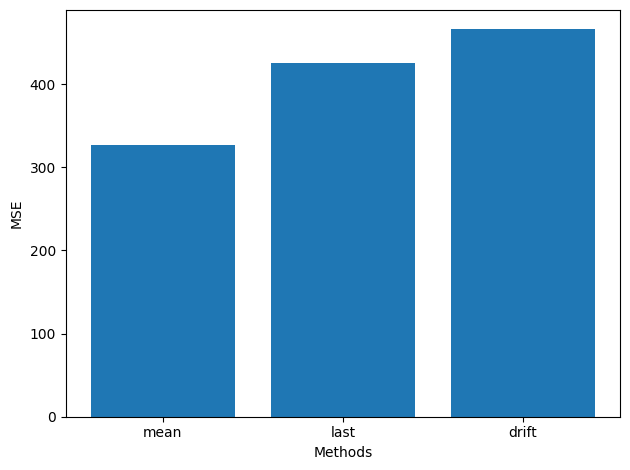

In [107]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last'])
mse_drift = mean_squared_error(test['value'], test['pred_drift'])

fig, ax = plt.subplots()
ax: Axes
ax.bar(
    ['mean', 'last', 'drift'], 
    [mse_mean, mse_last, mse_drift]
)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
plt.tight_layout()

Forecasting a random walk on a long horizon does not make sense since the future value is dependent on the past value plus a random number, the randomness portion of magnified in a long horizon where many random numbers are added over the course of many timesteps.

0.93


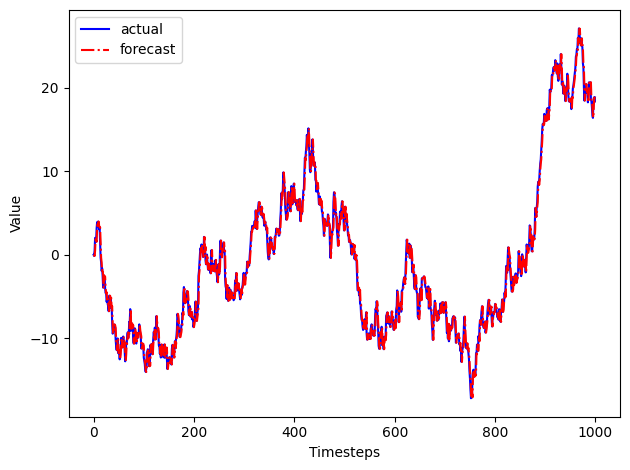

In [115]:
df_shift = df.shift(1) # shift values down by 1

fig, ax = plt.subplots()
ax: Axes
ax.plot(df, 'b-', label='actual')
ax.plot(df_shift, 'r-.', label='forecast')
ax.legend(loc=2)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
plt.tight_layout()

mse_one_step = mean_squared_error(test['value'], df_shift[train_test_split:])
print(f'{mse_one_step:.2f}')